In [1]:
import tensorflow as tf 
tf.test.gpu_device_name()

'/device:GPU:0'

In [2]:
from google.colab import files
upload = files.upload()

Saving 3-class.csv to 3-class.csv


In [4]:
up_list = files.upload()

Saving list.txt to list.txt


In [5]:
!mkdir outputs
!pip3 install keras_metrics

In [6]:
# -*- coding: utf-8 -*-
#-------------------------------------------------------------------------------

import itertools
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt


import re
from keras import regularizers
import sys
import codecs
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem.isri import ISRIStemmer
#from nltk.stem.arlstem import ARLSTem
import gensim
from gensim.models.word2vec import Word2Vec


import keras
from keras import layers
from keras import optimizers

from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.text import text_to_word_sequence
from keras.utils import to_categorical
import keras_metrics
from keras.layers import Embedding
from sklearn.model_selection import train_test_split

from keras.engine.topology import Layer

Using TensorFlow backend.


In [7]:
from keras.utils import get_file
cbow = get_file('cbow_100.zip', 'https://archive.org/download/aravec2.0/tweet_cbow_100.zip', extract=True)
cbow

253952000/253946430 [==============================] - 438s 2us/step


'/root/.keras/datasets/cbow_100.zip'

In [8]:
!ls /root/.keras/datasets/

cbow_100.zip	 tweets_cbow_100.trainables.syn1neg.npy
tweets_cbow_100  tweets_cbow_100.wv.vectors.npy


In [0]:
from pathlib import Path
cbow_path = Path('/root/.keras/datasets/tweets_cbow_100')

In [10]:
import keras.backend as K
K.clear_session()

In [11]:
data = pd.read_csv('3-class.csv', encoding='utf-8')
data = data.sample(frac=1).reset_index(drop=True)
print(data.shape)
data.head()

(56674, 2)


,Tweet,Polarity
0,مبروك ل عشاق البرشا ومبروك ل اجمل برشلونيه فط...,pos
1,برشلونه_روما توتي في لاعبين في برشلونه اقسم ب...,neut
2,نزل ياااااسر يادونيس الهلال_الشباب,neut
3,السماح_بالسينما_في_السعوديه للامانه احنا محتا...,pos
4,حذف_قناه_العربيه_من_الريسيفر حاذفتها مع بلوك ...,neg


In [12]:
data.sample(frac=1)

,Tweet,Polarity
28803,بخصوص تعليق_الدراسه_في_الرياض تعليق_الدراسه_ال...,neut
54680,عضو شرف النادي الاهلي تميم ال ثاني حضر من قطر...,pos
28263,1 فايز السبيعي مع الهلال 2 فايز السبيعي ضد ال...,neut
5371,الاعلام الحربي طيران التحالف يدمر 13 عجله لتن...,neut
50395,للملوك ترى كلنا نلاحظ هبوط مستوى اي لاعب ادعم...,neg
...,...,...
4808,احد يعلمي سر تالق الحراس قدام الهلال,pos
12880,الغدر شيمهم والقتل غايتهم وقطع الارحام صنيعته...,neg
18266,ميزانيتنا_عز_وليست_عجز رفع_اسعار_البنزين_والك...,neg
47553,مبروووك الف الف مبرووووك يانصر عوده الروح وال...,pos


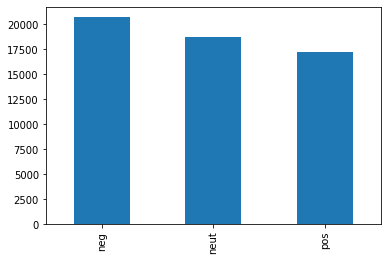

In [13]:
data['Polarity'].value_counts().sort_index().plot.bar()

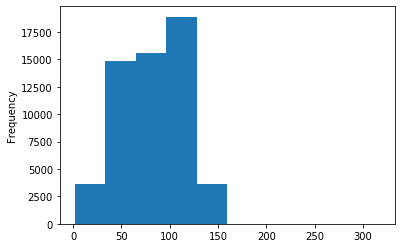

In [14]:
data['Tweet'].str.len().plot.hist()

In [15]:
def transform(x):
    if x == 'neg':
        return 0
    elif x == 'pos':
        return 1
    return 2
data['Sentiment'] = data['Polarity'].apply(transform)
data.head()

,Tweet,Polarity,Sentiment
0,مبروك ل عشاق البرشا ومبروك ل اجمل برشلونيه فط...,pos,1
1,برشلونه_روما توتي في لاعبين في برشلونه اقسم ب...,neut,2
2,نزل ياااااسر يادونيس الهلال_الشباب,neut,2
3,السماح_بالسينما_في_السعوديه للامانه احنا محتا...,pos,1
4,حذف_قناه_العربيه_من_الريسيفر حاذفتها مع بلوك ...,neg,0


In [16]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [17]:
#remove users
data['clean'] = data['Tweet'].apply(lambda x: re.sub('(@[A-Za-z]+)', '', x, flags=re.UNICODE))

#remove hashtags
#data['clean'] = data['clean'].apply(lambda x: re.sub('([أ-ي]+_[أ-ي]+)', '', x, flags=re.UNICODE))
#data['clean'] = data['clean'].apply(lambda x: re.sub('(_[أ-ي]+)', '', x, flags=re.UNICODE))
data['clean'] = data['clean'].apply(lambda x: re.sub('(_)', ' ', x, flags=re.UNICODE))
#remove letters, numbers & symbols
data['clean'] = data['clean'].apply(lambda x: re.sub('[a-zA-Z0-9@=$:.،%^*"#~£/&\n؟?!-_]', '', x, flags=re.UNICODE))

#arabic numbers
data['clean'] = data['clean'].apply(lambda x: re.sub('[٠١٢٣٤٥٦٧٨٩]', '', x, flags=re.UNICODE))

#nltk tokenize
data['clean'].apply(word_tokenize)
data['clean'] = data['clean'].apply(word_tokenize) 

#repeated letters
data['clean']= data['clean'].apply(lambda x: [''.join(ch for ch, _ in itertools.groupby(y)) for y in x])

#normalization
def normalizeArabic(text):
    text = re.sub("[إأٱآا]", "ا", text)
    text = re.sub("ى", "ي", text)
    text = re.sub("ؤ", "و", text)
    text = re.sub("ئ", "ء", text)
    text = re.sub("ة", "ه", text)
    return(text)
data['clean']= data['clean'].apply(lambda x: [normalizeArabic(y) for y in x])

#remove stopwords
def get_stop_words():
    path = 'list.txt'
    stop_words = []
    with codecs.open(path, "r", encoding="utf-8", errors="ignore") as myfile:
        stop_words = myfile.readlines()
    stop_words = [word.strip() for word in stop_words]
    return stop_words

stop_words = get_stop_words()
data['clean']= data['clean'].apply(lambda x: [item for item in x if item not in stop_words])

#remove emojis
def remove_emoji(text):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)

data['clean']= data['clean'].apply(lambda x: [remove_emoji(y) for y in x])

data.head(10)

,Tweet,Polarity,Sentiment,clean
0,مبروك ل عشاق البرشا ومبروك ل اجمل برشلونيه فط...,pos,1,"[مبروك, عشاق, البرشا, ومبروك, اجمل, برشلونيه, ..."
1,برشلونه_روما توتي في لاعبين في برشلونه اقسم ب...,neut,2,"[برشلونه, روما, توتي, لاعبين, برشلونه, اقسم, ب..."
2,نزل ياااااسر يادونيس الهلال_الشباب,neut,2,"[نزل, ياسر, يادونيس, الهلال, الشباب]"
3,السماح_بالسينما_في_السعوديه للامانه احنا محتا...,pos,1,"[السماح, بالسينما, السعوديه, لامانه, احنا, محت..."
4,حذف_قناه_العربيه_من_الريسيفر حاذفتها مع بلوك ...,neg,0,"[حذف, قناه, العربيه, الريسيفر, حاذفتها, بلوك, ..."
5,سرعه وين والانترنت يجيب الهم شوفو لنا حل مع ا...,neg,0,"[سرعه, وين, والانترنت, يجيب, الهم, شوفو, لنا, ..."
6,حصار_غزه_جريمه_اباده اللهم كن لاخواننا في غزه...,neg,0,"[حصار, غزه, جريمه, اباده, الهم, لاخوانا, غزه, ..."
7,السماح_بالسينما_في_السعوديه جس نبض الشارع وتم...,neut,2,"[السماح, بالسينما, السعوديه, جس, نبض, الشارع, ..."
8,الزوري هدفين الزوري ينقذ الهلال نهايه العالم,pos,1,"[الزوري, هدفين, الزوري, ينقذ, الهلال, نهايه, ا..."
9,من زمان والاتصالات تلعب علينا بفواتيرها واجهزت...,neg,0,"[زمان, والاتصالات, تلعب, علينا, بفواتيرها, واج..."


In [18]:
CBOW = Word2Vec.load(str(cbow_path))
CBOWE = CBOW.wv.get_keras_embedding()

/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:402: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


In [0]:
y = to_categorical(data['Sentiment'].values)

In [20]:
tokenizer = Tokenizer(num_words=len(data['clean']), split=" ")
tokenizer.fit_on_texts(data['clean'].values)

X = tokenizer.texts_to_sequences(data['clean'].values)
X = pad_sequences(X) # padding our text vector so they all have the same length
X[:5]

array([[    0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
           12,   967,   355,   745,   123,  8110, 24258,     7,     8],
       [    0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     7,     8,  2243,   182,     7,   531,   131,
         2876,   289, 35697,     8,  2244,   661,   503,  1472,  3619],
       [    0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,  1953,   107,  1698,     1,    40],
       [    0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,    22,
           24,     3,  1842,   565,  8961,  9986,  2321,  7434, 15158],
       [    0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
  

In [21]:
X.shape

(56674, 27)

In [0]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [0]:
#Metrics
def plot_data(H, EPOCHS, name='figure.png'):
    # plot the losses
    plt.style.use("ggplot")
    plt.figure()
    plt.plot(np.arange(0, EPOCHS), H['acc'],
        label="Accuracy")
    plt.plot(np.arange(0, EPOCHS), H['val_acc'],
        label="Val_Accuracy")
    plt.plot(np.arange(0, EPOCHS), H['loss'],
        label="Loss")
    plt.plot(np.arange(0, EPOCHS), H['val_loss'],
        label="Val_Loss")
    plt.xlabel("Epoch #")
    plt.ylabel("Accuracy & Loss")
    plt.legend(loc="upper right")
    plt.show()
    if name:
        plt.savefig(name)

In [0]:
#calculation
from keras import backend as K


# calculate f score
def f1(y_true, y_pred):
    def recall(y_true, y_pred):
        """Recall metric.

        Only computes a batch-wise average of recall.

        Computes the recall, a metric for multi-label classification of
        how many relevant items are selected.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

    def precision(y_true, y_pred):
        """Precision metric.

        Only computes a batch-wise average of precision.

        Computes the precision, a metric for multi-label classification of
        how many selected items are relevant.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision
    precision = precision(y_true, y_pred)
    recall = recall(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [0]:
# metrics all
metrics = [
    'accuracy',
    keras_metrics.precision(),
    keras_metrics.recall(),
    f1,
]

In [0]:
# hyperparamters
BATCH_SIZE = 32
LEARNING_RATE = 0.001
VALIDATION_SPLIT = 0.2
EPOCHS = 20

In [0]:
#build model
def buildAndRunModel(model, ckpt_path):
    # callbacks
    checkpoints = keras.callbacks.ModelCheckpoint(ckpt_path, monitor='val_loss', save_best_only=True, save_weights_only=False)
    
    model.compile(loss='categorical_crossentropy', 
                   optimizer='adam',
                   metrics=metrics,)
    H = model.fit(X_train, y_train, 
               validation_split=VALIDATION_SPLIT, 
               batch_size=BATCH_SIZE, 
               epochs=EPOCHS,
               callbacks=[checkpoints],)
    return H

In [0]:
def eval_model(model):
    E = model.evaluate(X_test, y_test)
    return list(zip(E, model.metrics_names))

In [29]:


#Stacked-GRU

gru_model_input = layers.Input(shape=(X_train.shape[1],))
embed = CBOWE(gru_model_input)

forw = layers.GRU(100, return_sequences=True, dropout=0.5)(embed)
backw = layers.GRU(100, return_sequences=True, go_backwards=True, dropout=0.5)(embed)
link= layers.Concatenate()([forw,backw])

forw2 = layers.GRU(100, return_sequences=True, dropout=0.5)(link)
backw2 = layers.GRU(100, return_sequences=True, go_backwards=True, dropout=0.5)(link)
link2= layers.Concatenate()([forw2,backw2])

x1 = layers.Flatten()(link2)
x2 = layers.Dense(100, activation='relu', name='desne1')(x1)
x3 = layers.Dense(3, activation='softmax', name='desne_output')(x2)

gru_model = keras.models.Model(inputs=gru_model_input, outputs=x3)









Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [30]:
gru_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 27)           0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 27, 100)      33167900    input_1[0][0]                    
__________________________________________________________________________________________________
gru_1 (GRU)                     (None, 27, 100)      60300       embedding_1[0][0]                
__________________________________________________________________________________________________
gru_2 (GRU)                     (None, 27, 100)      60300       embedding_1[0][0]                
____________________________________________________________________________________________

In [31]:
%%time
GRU_H = buildAndRunModel(gru_model, 'gru_ckpt')




Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where

Train on 36271 samples, validate on 9068 samples
Epoch 1/20
36271/36271 [==============================] - 221s 6ms/step - loss: 1.0195 - acc: 0.4739 - precision: 0.5375 - recall: 0.1941 - f1: 0.2748 - val_loss: 0.8790 - val_acc: 0.5892 - val_precision: 0.5850 - val_recall: 0.6563 - val_f1: 0.5499
Epoch 2/20
36271/36271 [==============================] - 216s 6ms/step - loss: 0.9035 - acc: 0.5697 - precision: 0.5994 - recall: 0.4596 - f1: 0.4949 - val_loss: 0.8278 - val_acc: 0.6302 - val_precision: 0.6139 - val_recall: 0.6902 - val_f1: 0.6097
Epoch 3/20
36271/36271 [==============================] - 215s 6ms/step - loss: 0.8614 - acc: 0.5998 - precision: 0.6324 - recall: 0.5027 - f1: 0.5456 - val_loss: 0.7938 - val_acc: 0.6511 - val_precision: 0.7060 - val_recall: 0.5451 - val_f1: 0.6292
Epoch 4/20
36271/36271 [==============================] - 214s 6ms/step - loss: 0.8390 - acc: 0.6131 - 

In [32]:
eval_model(gru_model)

11335/11335 [==============================] - 29s 3ms/step


[(0.7775076644137718, 'loss'),
 (0.6886634318587745, 'acc'),
 (0.7141693810881061, 'precision'),
 (0.6306327900136474, 'recall'),
 (0.6784257781311022, 'f1')]

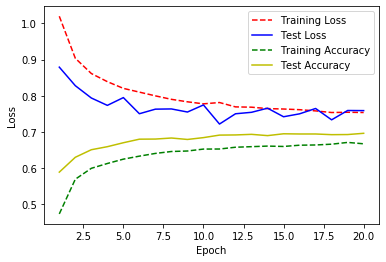

In [33]:
training_loss = GRU_H.history['loss']
test_loss = GRU_H.history['val_loss']
training_acc = GRU_H.history['acc']
test_acc = GRU_H.history['val_acc']
# Create count of the number of epochs
epoch_count = range(1, len(training_loss) + 1)

# Visualize loss history
plt.plot(epoch_count, training_loss, 'r--')
plt.plot(epoch_count, test_loss, 'b-')
plt.plot(epoch_count, training_acc, 'g--')
plt.plot(epoch_count, test_acc, 'y-')
plt.legend(['Training Loss', 'Test Loss', 'Training Accuracy', 'Test Accuracy'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show();